As an international student in the U.S., I am interested in forecasting the exchange rate of USD to INR. To achieve this, I plan to perform a time series analysis to predict the value of INR against USD over time

Getting the daily exchange rate data of USD to INR

In [2]:
import requests

f2 = open("alphavantageapikey.txt", "r")
api_key = f2.read()
f2.close()

url = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=INR&apikey=' + api_key + '&outputsize=full&datatype=csv'
r = requests.get(url)
print(r.status_code)
with open('forex.csv', 'wb') as f:
  f.write(r.content)




200


The **ARIMA (AutoRegressive Integrated Moving Average)** model is a popular statistical method used for analyzing and forecasting time series data. It combines three key components:

**AutoRegressive (AR)**:

Represents the relationship between an observation and a specified number of lagged (past) observations.
Example: If the current value depends on the previous value(s), it’s captured by AR terms.

**Integrated (I)**:

Represents the differencing of observations to make the time series stationary (i.e., to remove trends or seasonality).
Example: Subtracting the previous value from the current value to remove trends.

**Moving Average** (MA):

Represents the relationship between an observation and the residual errors from a moving average model applied to lagged observations.
Example: If the current value depends on past forecast errors, it’s captured by MA terms.

**ARIMA Parameters**:
The model is denoted as ARIMA(p, d, q), where:

p: The number of lagged observations for the AR term.

d: The number of differences required to make the series stationary.

q: The size of the moving average window or lag of error terms.



In [3]:
import pandas as pd
df = pd.read_csv('forex.csv')
df.head()

,timestamp,open,high,low,close
0,2025-01-17,86.5680,86.6230,86.4910,86.5290
1,2025-01-16,86.6061,86.6692,86.0648,86.6061
2,2025-01-15,86.4310,86.6422,86.2521,86.4310
3,2025-01-14,86.5354,86.5988,86.1093,86.5354
4,2025-01-13,86.6506,86.8553,86.4441,86.6506


In [4]:
df = df.iloc[::-1]

In [5]:
df.shape

(2607, 5)

In [6]:
df.isna().sum()

,0
timestamp,0
open,0
high,0
low,0
close,0


In [7]:
df = df.reset_index(drop=True)
df

,timestamp,open,high,low,close
0,2015-01-18,61.8630,61.8630,61.5100,61.8630
1,2015-01-19,61.6600,61.8880,61.6100,61.6380
2,2015-01-20,61.6200,61.7100,61.4100,61.6480
3,2015-01-21,61.5200,61.7700,61.3300,61.5530
4,2015-01-22,61.5300,61.5980,61.2300,61.5980
...,...,...,...,...,...
2602,2025-01-13,86.6506,86.8553,86.4441,86.6506
2603,2025-01-14,86.5354,86.5988,86.1093,86.5354
2604,2025-01-15,86.4310,86.6422,86.2521,86.4310
2605,2025-01-16,86.6061,86.6692,86.0648,86.6061


I will be trying to predict the closing exchange rate of USD w.r.t INR.

In [8]:
split_point = int(len(df) * 0.8)
df_close = df[['close']].copy()
train_data = df_close.iloc[:split_point]
test_data = df_close.iloc[split_point:]

In [9]:
train_data

,close
0,61.8630
1,61.6380
2,61.6480
3,61.5530
4,61.5980
...,...
2080,81.6318
2081,81.1156
2082,81.2780
2083,81.6526


In [10]:
test_data

,close
2085,81.4360
2086,81.2398
2087,80.9760
2088,81.4880
2089,81.6019
...,...
2602,86.6506
2603,86.5354
2604,86.4310
2605,86.6061


The **Augmented Dickey-Fuller (ADF)** Test is a statistical test used to determine whether a time series is stationary or has a unit root. A time series is non-stationary if it exhibits a unit root, meaning the value at time t depends heavily on its previous value at time t-1. The ADF test checks for the presence of a unit root:

Null Hypothesis : The time series has a unit root (i.e., it is non-stationary).
Alternative Hypothesis : The time series does not have a unit root (i.e., it is stationary).
If the p-value is below a chosen significance level (e.g., 0.05), reject null hypothesis, concluding that the series is stationary.

In [11]:
from statsmodels.tsa.stattools import adfuller
print("ADF test p-value :", adfuller(train_data)[1])

ADF test p-value : 0.8399624049521783


Since p-value of ADF test is greater than 0.05, we can conclude that the series is non-stationary.

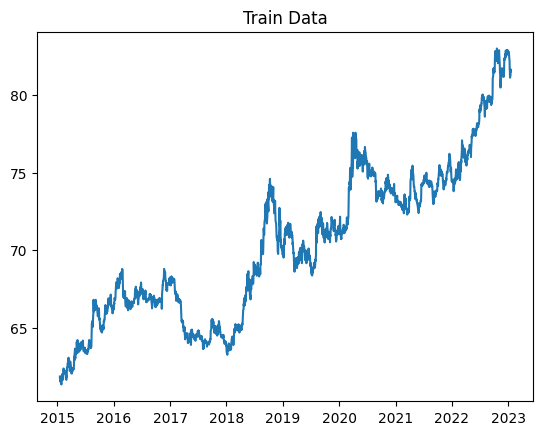

In [12]:
import matplotlib.pyplot as plt
df['timestamp'] = pd.to_datetime(df['timestamp'])
plt.plot(df['timestamp'].iloc[:split_point],train_data)
plt.title('Train Data')
plt.show()

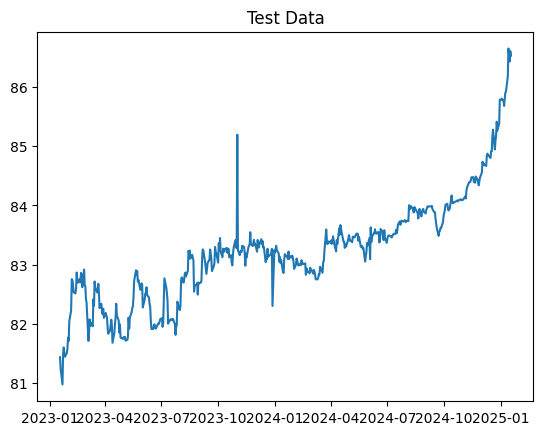

In [14]:
plt.plot(df['timestamp'].iloc[split_point:],test_data)
plt.title('Test Data')
plt.show()

**Autocorrelation Function (ACF)**: Measures the correlation between a time series and its lagged values across different lags.

Use ACF to understand overall patterns and determine the MA order. (q term)

**Partial Autocorrelation Function (PACF**): Measures the correlation between a time series and its lagged values after removing the effects of intermediate lags.

Use PACF to understand direct relationships and determine the AR order. (p term)

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Plotting the time series data showing the variation of exchange rate of USD w.r.t INR.

In [16]:
train_data_time = df['timestamp'].iloc[:split_point]
test_data_time = df['timestamp'].iloc[split_point:]

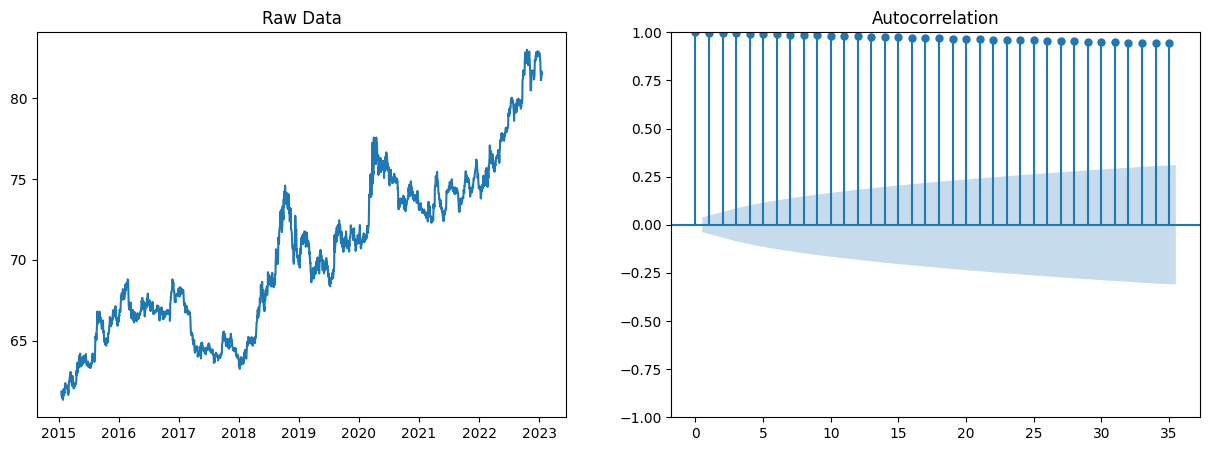

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(train_data_time,train_data)
ax1.set_title('Raw Data')
plot_acf(df_close, ax=ax2)
plt.show()

To deal with non stationary, we apply differencing to the time series data.

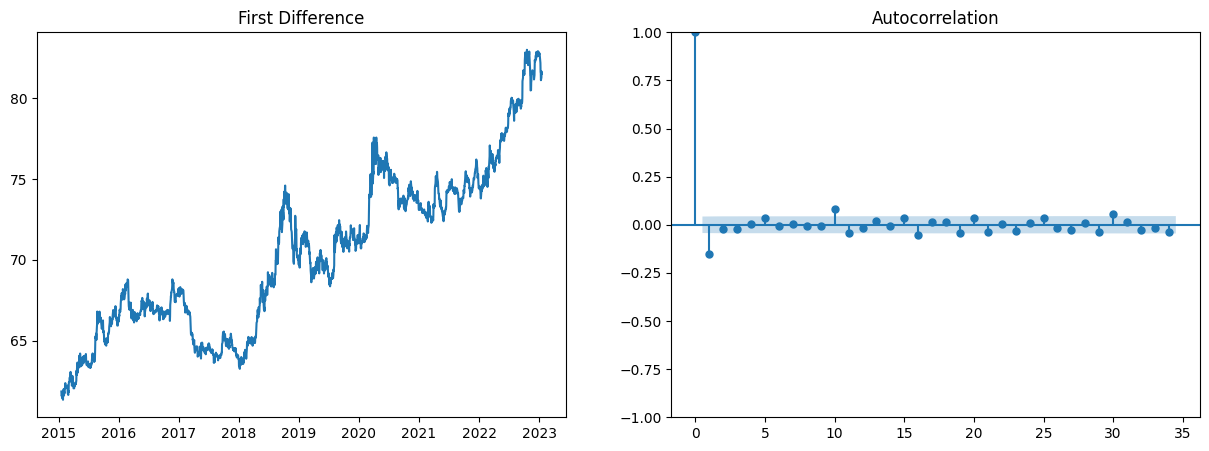

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(train_data_time,train_data)
ax1.set_title('First Difference')
plot_acf(train_data.diff().dropna(), ax=ax2)
plt.show()

After applying differencing for a second time, we can see the correlation between the terms increased. So we take the differencing order to be 1. Therefore, d=1.

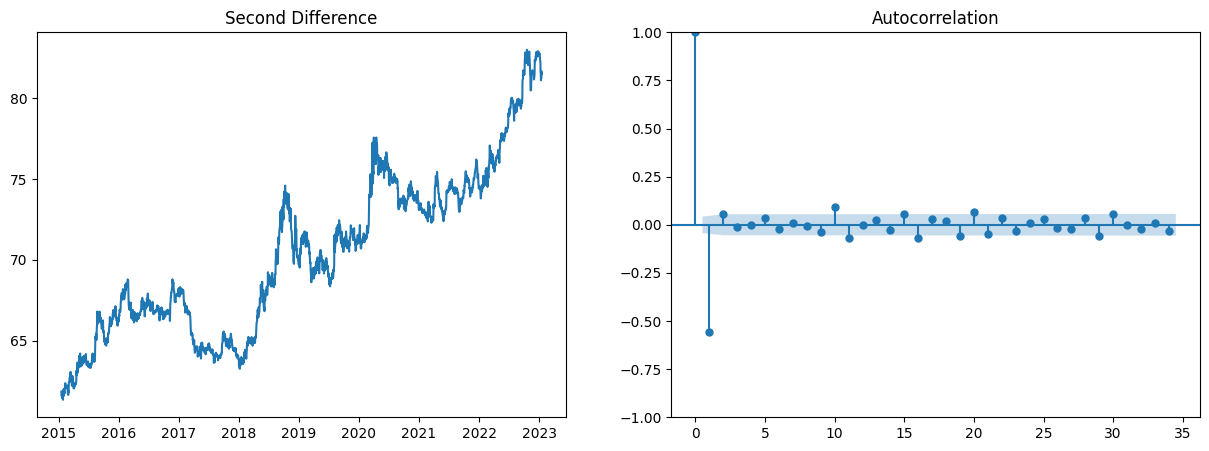

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(train_data_time,train_data)
ax1.set_title('Second Difference')
plot_acf(train_data.diff().diff().dropna(), ax=ax2)
plt.show()

From the above above acf plot we can see that the fourth lag term is slightly above the threshold so we can choose the MA term q=3.

We can also determine the differencing order using the pmdarima module.

In [20]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.9 MB/s eta 0:00:00


In [21]:
from pmdarima.arima import ndiffs
print('Suggested diffencing order:', ndiffs(train_data, test='adf'))

Suggested diffencing order: 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

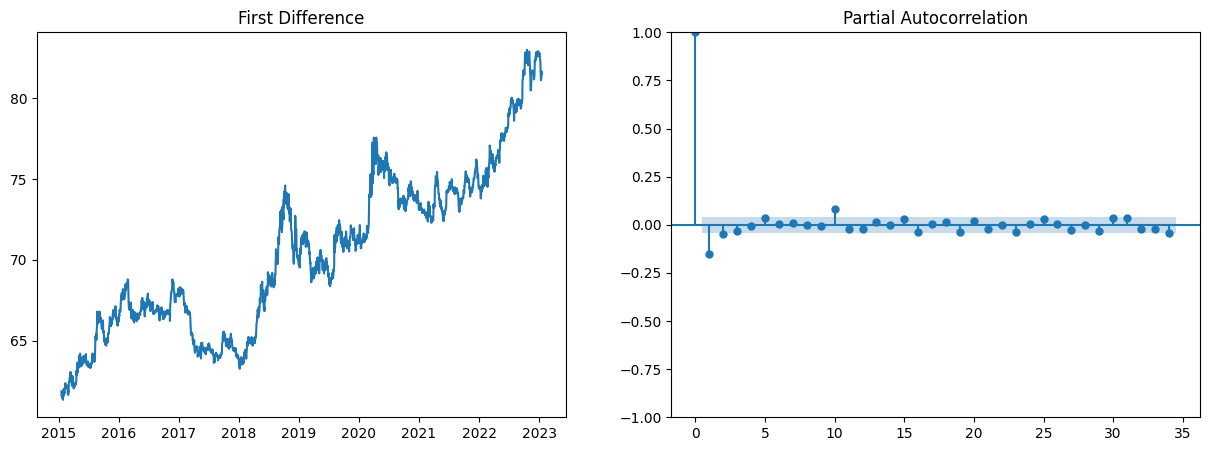

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(train_data_time,train_data)
ax1.set_title('First Difference')

plot_pacf(train_data.diff().dropna(), ax=ax2)
plt.show()

Looking the pacf plot, we can see that the lag term number 2 or 3 is slightly greater that the threshold. So we can choose p=3 for our ARIMA model

**Chosen ARIMA model**

In [23]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2085
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -316.489
Date:                Sat, 18 Jan 2025   AIC                            642.977
Time:                        22:58:21   BIC                            671.187
Sample:                             0   HQIC                           653.314
                               - 2085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1609      0.118      9.846      0.000       0.930       1.392
ar.L2         -0.2821      0.088     -3.209      0.001      -0.454      -0.110
ma.L1         -1.3162      0.116    -11.378      0.0

Forecasting the test data based on the model created using the train data.

In [51]:
fc = model_fit.get_forecast(steps=len(test_data), alpha=0.05)
print(fc.predicted_mean)

2085    81.499620
2086    81.484258
2087    81.473723
2088    81.465828
2089    81.459632
          ...    
2602    81.433079
2603    81.433079
2604    81.433079
2605    81.433079
2606    81.433079
Name: predicted_mean, Length: 522, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Confidence Interval for the forecasted values.

In [52]:
conf = fc.conf_int()
print(conf)

      lower close  upper close
2085    80.947603    82.051637
2086    80.761640    82.206876
2087    80.624729    82.322718
2088    80.506882    82.424773
2089    80.399542    82.519723
...           ...          ...
2602    70.172639    92.693520
2603    70.161749    92.704409
2604    70.150870    92.715288
2605    70.140002    92.726157
2606    70.129144    92.737014

[522 rows x 2 columns]


In [53]:
fc = pd.Series(fc.predicted_mean, index = test_data.index)

lower = pd.Series(conf['lower close'], index = test_data.index)
upper = pd.Series(conf['upper close'], index = test_data.index)

Plotting the forecasted values vs the actual values. Also showing the confidence interval which shows that the actual values are within the forecasted confidence interval.

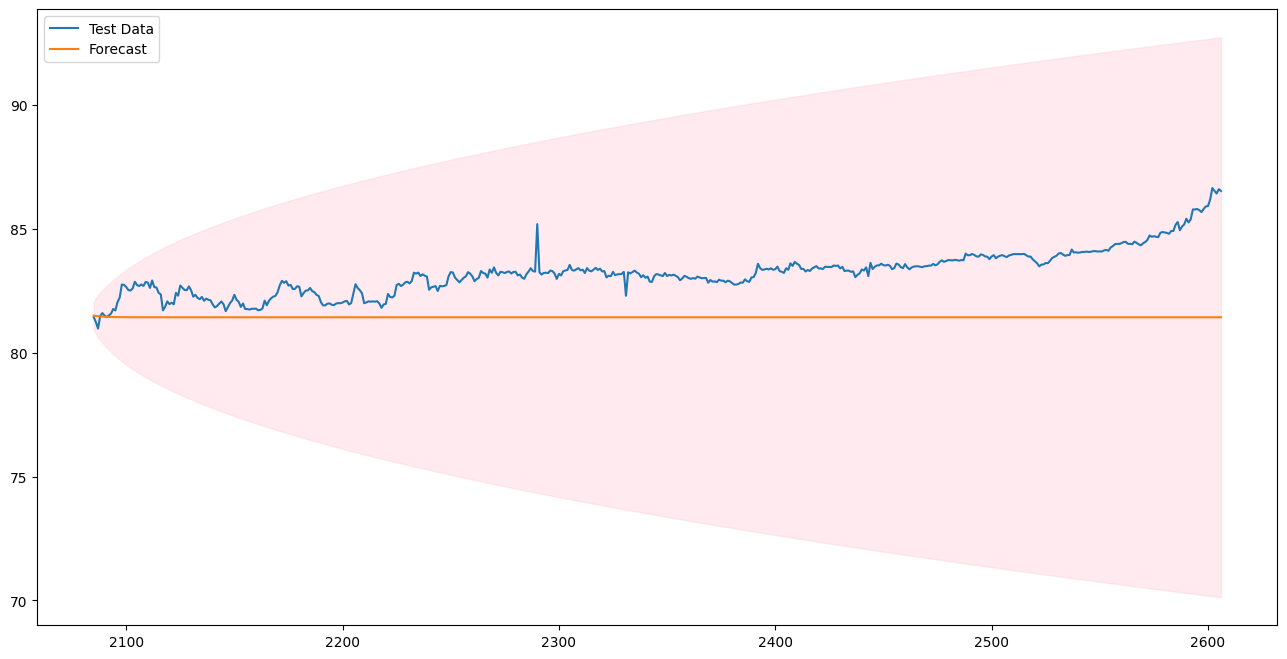

In [55]:
plt.figure(figsize=(16, 8))
plt.plot(test_data, label='Test Data')
plt.plot(fc, label='Forecast')
plt.fill_between(lower.index, lower, upper, color='pink', alpha=0.3)
plt.legend()
plt.show()


Based on the plot above, we can observe that while the ARIMA model serves as a useful baseline for predicting time-dependent values, its accuracy still leaves room for improvement. The actual values are around 86, while the predicted mean hovers around 82. However, when considering the upper limit of the confidence interval, which is 92, the actual value falls within the predicted range. This suggests that, for a rough estimation of future values, the ARIMA model can be utilized effectively, taking into account not just the predicted mean but also the confidence interval bounds.

That being said, for more precise forecasting, a more advanced and accurate prediction model should be explored. This will be the focus of the next phase of the project, as we aim to enhance the prediction's reliability and accuracy.

In [31]:
from sklearn.metrics import mean_squared_error

# Generate predictions for the test data
start_index = split_point
end_index = df_close.index[-1]
print(start_index, end_index)
predictions = model_fit.predict(start = start_index, end = end_index)

# Evaluate the model
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error: {mse}")

2085 2606
Mean Squared Error: 4.044778733619201


The selection of the parameters p, d, and q for the ARIMA model can be automated using the auto_arima function from the pmdarima library. This approach simplifies the process by automatically identifying the optimal parameters based on the data.

Now, we will try to predict the foreign exchange rate of USD in terms of INR for the month of February 2025.


In [56]:
from pmdarima import auto_arima
model = auto_arima(df_close, seasonal=False, trace=True,
                   error_action='ignore', suppress_warnings=True)

print(model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=476.810, Time=5.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=549.024, Time=0.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=479.005, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=472.934, Time=1.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=550.257, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=472.811, Time=1.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=474.785, Time=4.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=474.795, Time=2.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=473.051, Time=0.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=474.880, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=476.099, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 18.431 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2607
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -232.406
Date:                Sun, 19 Jan 2025   AIC                            472.811
Time:                        00:14:12   BIC                            496.274
Sample:                             0   HQIC                           481.311
                               - 2607                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0080      0.004      2.227      0.026       0.001 

In [67]:
forecast_steps = 60
forecast_values, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
print(conf_int)

[[86.02734865 87.06430598]
 [85.88416938 87.22876587]
 [85.77674027 87.35552471]
 [85.68545317 87.46583395]
 [85.60459684 87.56566393]
 [85.53140731 87.65781946]
 [85.46420059 87.74399097]
 [85.40183811 87.82531806]
 [85.34350329 87.90261746]
 [85.28858624 87.97649908]
 [85.23661704 88.04743285]
 [85.1872245  88.11578996]
 [85.14010936 88.18186966]
 [85.09502616 88.24591744]
 [85.05177059 88.30813757]
 [85.01017046 88.36870228]
 [84.97007901 88.4277583 ]
 [84.93136997 88.4854319 ]
 [84.89393378 88.54183267]
 [84.8576746  88.59705642]
 [84.82250806 88.65118753]
 [84.78835941 88.70430075]
 [84.75516205 88.75646268]
 [84.72285635 88.80773294]
 [84.69138866 88.85816521]
 [84.66071048 88.90780796]
 [84.63077785 88.95670516]
 [84.60155073 89.00489685]
 [84.57299252 89.05241963]
 [84.54506971 89.09930701]
 [84.51775149 89.1455898 ]
 [84.49100945 89.19129641]
 [84.46481735 89.23645308]
 [84.43915087 89.28108413]
 [84.41398745 89.32521212]
 [84.38930608 89.36885806]
 [84.36508719 89.41204152]
 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [76]:
start_value = 2607
fc_auto = pd.Series(forecast_values, index = pd.Index(range(start_value, start_value + 60)))

lower = pd.Series(conf_int[:,0], index = pd.Index(range(start_value, start_value + 60)))
upper = pd.Series(conf_int[:,1], index = pd.Index(range(start_value, start_value + 60)))

start_date = '2025-01-18'

date_series = pd.date_range(start=start_date, periods=60, freq='D')
print(date_series)

DatetimeIndex(['2025-01-18', '2025-01-19', '2025-01-20', '2025-01-21',
               '2025-01-22', '2025-01-23', '2025-01-24', '2025-01-25',
               '2025-01-26', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31', '2025-02-01', '2025-02-02',
               '2025-02-03', '2025-02-04', '2025-02-05', '2025-02-06',
               '2025-02-07', '2025-02-08', '2025-02-09', '2025-02-10',
               '2025-02-11', '2025-02-12', '2025-02-13', '2025-02-14',
               '2025-02-15', '2025-02-16', '2025-02-17', '2025-02-18',
               '2025-02-19', '2025-02-20', '2025-02-21', '2025-02-22',
               '2025-02-23', '2025-02-24', '2025-02-25', '2025-02-26',
               '2025-02-27', '2025-02-28', '2025-03-01', '2025-03-02',
               '2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06',
               '2025-03-07', '2025-03-08', '2025-03-09', '2025-03-10',
               '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14',
      

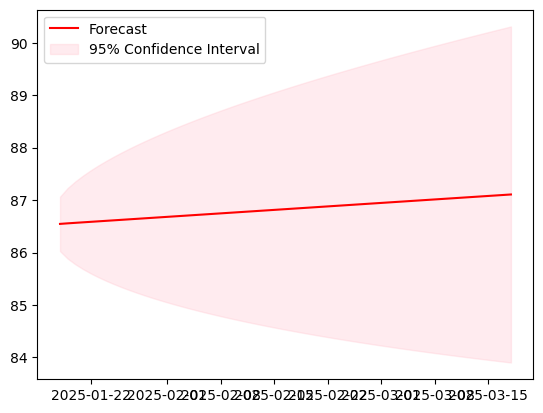

In [74]:
# plt.plot(df['timestamp'],df_close, label='Data')
plt.plot(date_series, fc_auto, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(date_series, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.legend()
plt.show()

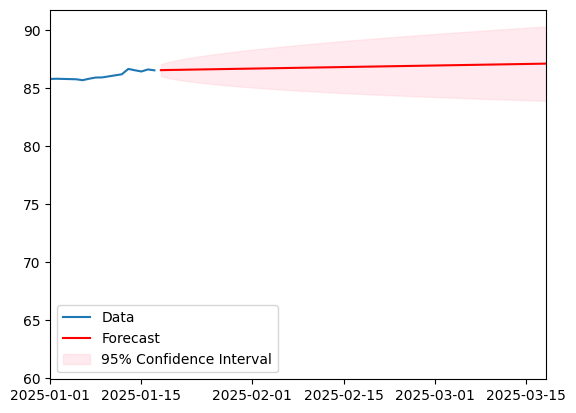

In [79]:
plt.plot(df['timestamp'],df_close, label='Data')
plt.plot(date_series, fc_auto, label='Forecast', color='red')
start_date = pd.to_datetime('2025-01-01')
end_date = pd.to_datetime('2025-03-18')

# Zoom in on the specific date range
plt.xlim(start_date, end_date)
# Plot the confidence intervals
plt.fill_between(date_series, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.legend()
plt.show()